## Load Packages

In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

# Connect to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

Mounted at /content/drive
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Wa476zxHXzlcHx7B4C8oV_VYbjmssl5CK6lr42C7YGg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiBCj9N3s_EKc4BaMXYx9dCB_0QM0CMvWe9jem5ST0ZGPOAyM210hY

Successfully saved authorization token.


In [2]:
from shapely.geometry import Polygon

In [3]:
!pip install geopandas
#!pip install rioxarray
!pip install geojson
#!pip install rasterstats
!pip install geemap
!pip install scikit-learn
!pip install seaborn

import os
from glob import glob
import numpy as np
import pandas as pd
import geojson
import shapely as shp
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
#import xarray as xr
#import rioxarray as rioxr
import geemap
from sklearn.metrics import roc_curve, auc
#import gdal
import seaborn as sns

     |████████████████████████████████| 1.0 MB 31.3 MB/s 
     |████████████████████████████████| 6.3 MB 54.1 MB/s 
     |████████████████████████████████| 16.7 MB 63.8 MB/s 
     |████████████████████████████████| 1.9 MB 21.8 MB/s 
     |████████████████████████████████| 5.4 MB 61.6 MB/s 
     |████████████████████████████████| 1.3 MB 48.4 MB/s 
     |████████████████████████████████| 76 kB 6.7 MB/s 
     |████████████████████████████████| 98 kB 9.0 MB/s 
     |████████████████████████████████| 8.5 MB 43.6 MB/s 
     |████████████████████████████████| 130 kB 54.0 MB/s 
     |████████████████████████████████| 1.7 MB 44.4 MB/s 
     |████████████████████████████████| 99 kB 10.0 MB/s 
     |████████████████████████████████| 1.2 MB 54.5 MB/s 
     |████████████████████████████████| 216 kB 58.6 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 95 kB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 56.3 MB/s 
     |████████████████

## User-defined Functions

In [4]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [5]:
# Function to add water Index bands
def addIndex(image):
  ndwi = image.normalizedDifference(['green', 'nir']).rename(['ndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431169608948714
  
  mndwi = image.normalizedDifference(['green', 'swir1']).rename(['mndwi'])
  # https://www.tandfonline.com/doi/abs/10.1080/01431160600589179
  
  awei = image.expression("blue + 2.5*green - 1.5*(nir+swir1) - 0.25*swir2", {
    'blue': image.select(['blue']),
    'green': image.select(['green']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['awei'])
  # https://www.sciencedirect.com/science/article/pii/S0034425713002873
  
  wiFi = image.expression("1.7204 + 171*green +3*red - 70*nir - 45*swir1 - 71*swir2",{
    'green': image.select(['green']),
    'red': image.select(['red']),
    'nir': image.select(['nir']),
    'swir1': image.select(['swir1']),
    'swir2': image.select(['swir2'])
  }).rename(['wiFi'])
  # https://www.sciencedirect.com/science/article/abs/pii/S0034425715302753
  
  return image.addBands([ndwi, mndwi, awei, wiFi])


In [6]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [7]:
# Function of Otsu's Method
def get_threshold(image):
  #indices = ['ndwi', 'mndwi', 'awei', 'wiFi']
  #indices = ['wiFi']
  indices = waterIndices

  histograms = [image.select([i]).reduceRegion(
      reducer = ee.Reducer.histogram().combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      maxPixels = 10e12,
      bestEffort = True) for i in indices]

  thrhs = [otsu(h.get(i+'_histogram')) for h,i in zip(histograms,indices)]

  return thrhs

In [8]:
def get_mask(image, threshold):
  indices = waterIndices
  watermasks = [image.select([i]).gt(t).rename(['watermask_'+i]).unmask(0) for i,t in zip(indices,threshold)]
  # Water = 1, Land = 0
  return watermasks

## Load ROIs (parcel)

In [9]:
# Load all parcels
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
path_parcels = glob(os.path.join(os.getcwd(), 'parcels.geojson'))[0]
parcels = gpd.read_file(path_parcels).sort_values('TARGET_FID')

parcels.head()

,fid,TARGET_FID,GID_0,NAME_0,Shape_Area,geometry
0,1,215,JPN,Japan,7.774520e+10,"MULTIPOLYGON (((147.70812 43.07955, 146.24364 ..."
1,2,216,JPN,Japan,6.692903e+10,"MULTIPOLYGON (((143.48255 43.51240, 142.55864 ..."
51,52,336,JPN,Japan,6.854787e+10,"MULTIPOLYGON (((143.48255 43.51240, 145.36744 ..."
52,53,455,JPN,Japan,4.888277e+10,"MULTIPOLYGON (((142.54397 46.95565, 142.55864 ..."
53,54,462,CHN,China,8.068226e+10,"MULTIPOLYGON (((132.39052 41.62522, 130.12027 ..."


In [10]:
# Get Parcel IDs
#parcelIDs = sorted(list(parcels['TARGET_FID']))
parcelIDs = [667, 669, 671]
print(parcelIDs)

[667, 669, 671]


In [11]:
#parcels.to_file('parcels.geojson', driver='GeoJSON')
with open('parcels.geojson') as f:
  parcels_geojson = geojson.load(f)

## GEE: Get Otsu's Threshold (processing at parcel level)

In [12]:
# Define roi
parcelID = parcelIDs[0]
ROI = [i['geometry'] for i in parcels_geojson['features'] if i['properties']['TARGET_FID']==parcelID]
roi = ee.Geometry(ROI[0])
roi.getInfo()

{'coordinates': [[[100.932197, 10.477662],
   [98.97558, 9.352137],
   [99.325184, 8.415768],
   [99.758921, 7.801499],
   [101.907841, 8.82988],
   [101.454641, 9.699979],
   [100.932197, 10.477662]]],
 'type': 'Polygon'}

In [13]:
# Load Landsat Archives
ls8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
        .filterDate('2019', '2020') \
        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
        .filterBounds(roi) \
        .sort("system:time_start", True)
ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
      .filterDate('2019', '2020') \
      .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'], ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']) \
      .filterBounds(roi) \
      .sort("system:time_start", True)

# Merge Collections + Mask Cloud + Add water index bands
ls_all = ls8.merge(ls7)
ls_all = ls_all.sort('system:time_start', True).map(maskCloud).map(addIndex)

In [19]:
# Reduce by Median
img2019_median = ls_all.median().set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)}).select(['wiFi'])
img2019_median.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 11796307.7204,
    'min': -11796292.2796,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'wiFi'}],
 'properties': {'system:time_start': {'type': 'Date', 'value': 1577750400000},
  'year': 2019},
 'type': 'Image'}

In [23]:
# Reduce by 95th percentile
img_95th = ls_all.reduce(ee.Reducer.percentile([95])).set({'year': 2019, 'system:time_start': ee.Date.fromYMD(2019, 12, 31)}).select(['wiFi_p95'])
img_95th = img_95th.rename(['wiFi'])
img_95th.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 11796307.7204,
    'min': -11796292.2796,
    'precision': 'double',
    'type': 'PixelType'},
   'id': 'wiFi'}],
 'properties': {'system:time_start': {'type': 'Date', 'value': 1577750400000},
  'year': 2019},
 'type': 'Image'}

In [25]:
# Apply Otsu
waterIndices = ['wiFi']
threshold_origin = get_threshold(img_95th)[0]
threshold_origin.getInfo()

-82428.22693404491

## GEE: Rasterize Ponds at Test Site
* https://developers.google.com/earth-engine/guides/reducers_reduce_to_image
* https://gis.stackexchange.com/questions/333710/points-to-raster-image-in-google-earth-engine/334148

In [ ]:
os.chdir('/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/')
testSites = glob(os.path.join(os.getcwd(), "*"))
testSites

['/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/p_667_A.geojson',
 '/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/p_671_A.geojson',
 '/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/ROC_testSites/p_669_A.geojson']

In [ ]:
with open(testSites[0].split('/')[-1]) as f:
  testSite_geojson = geojson.load(f)

In [ ]:
geoms = [ee.Geometry(i['geometry']) for i in testSite_geojson['features']]
features = [ee.Feature(i) for i in geoms]
featCol = ee.FeatureCollection(features).map(lambda feature: feature.set('ref', 1))
#featCol.getInfo()

In [ ]:
bbox = featCol.union().geometry().bounds()
img_ref = featCol.reduceToImage(['ref'], ee.Reducer.firstNonNull()).unmask(0).clip(bbox)
img_ref = img_ref.rename(['reference'])
#img_ref.getInfo()

In [ ]:
Map = geemap.Map(center=(20, 110), zoom=3)
Map.addLayer(featCol, {}, 'ponds in test', False)
Map.addLayer(img_ref, {'palette':['grey', 'blue'], 'min':0, 'max':1}, 'reference')
Map

Map(center=[20, 110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

## GEE: Get Water Mask (at Test-site Level)

In [ ]:
img_test = get_mask(image = img2019_median, threshold = threshold_origin)[0].clip(bbox)
img_test = img_test.rename(['test_wiFi_median'])
img_test.getInfo()

{'bands': [{'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0],
   'data_type': {'max': 1, 'min': 0, 'precision': 'int', 'type': 'PixelType'},
   'dimensions': [1, 1],
   'id': 'test_wiFi_median',
   'origin': [99, 9]}],
 'properties': {'system:footprint': {'coordinates': [[[99.59334100000001,
      9.246448999999975],
     [99.61472100000002, 9.246448999999975],
     [99.61472100000002, 9.266841000226437],
     [99.59334100000001, 9.266841000226437],
     [99.59334100000001, 9.246448999999975]]],
   'geodesic': False,
   'type': 'Polygon'}},
 'type': 'Image'}

In [ ]:
Map.addLayer(img_test, {'palette':['grey', 'blue'], 'min':0, 'max':1}, 'Test')
Map

Map(bottom=1208.0, center=[20, 110], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

## Sample Test and Reference Image

In [ ]:
img_to_sample = img_test.addBands(img_ref)
#img_to_sample.getInfo()

In [ ]:
my_sample = img_to_sample.sample(bbox, 90)

print(my_sample.first().getInfo())
print(my_sample.size().getInfo())
type(my_sample)

{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'reference': 0, 'test_wiFi_median': 0}}
675


ee.featurecollection.FeatureCollection

In [ ]:
#my_sample = img_to_sample.sample(bbox, 90, geometries=True)
#Map.addLayer(my_sample, {'color':'yellow'}, 'samples')
#Map

In [ ]:
property_keys = my_sample.toDictionary().values().getInfo()[0]
print(property_keys)
property_values = [np.array(my_sample.aggregate_array(i).getInfo()) for i in property_keys]
property_dic = dict(zip(property_keys, property_values))

['test_wiFi_median', 'reference']


In [ ]:
pred_wiFi_median = property_dic.get(property_keys[0])
reference = property_dic.get(property_keys[1])

In [ ]:
fp = np.sum((pred_wiFi_median == 1) & (reference == 0))
tp = np.sum((pred_wiFi_median == 1) & (reference == 1))

fn = np.sum((pred_wiFi_median == 0) & (reference == 1))
tn = np.sum((pred_wiFi_median == 0) & (reference == 0))

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print(fpr, tpr)

0.08743169398907104 0.9061488673139159


## ROC-Curve

Calculate TPR and FPR: <br>
* https://stackoverflow.com/questions/61321778/how-to-calculate-tpr-and-fpr-in-python-without-using-sklearn?noredirect=1&lq=1



<br>
ROC-curve to find optimal threshold: <br>

* https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
* https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://stackoverflow.com/questions/36300334/understanding-argmax

In [ ]:
df = pd.DataFrame(property_dic)
df.head()

,test_wiFi_median,reference
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
import random

In [ ]:
tpr = list(np.random.uniform(0,1, size=50))
fpr = list(np.random.uniform(0,1, size=50))
thresholds = list(np.random.uniform(0.35, 0.5, size=50))
reducer = ['median', '95th']*25
waterIndex = ['mndwi', 'wifi']*25
random.shuffle(reducer)
random.shuffle(waterIndex)

In [ ]:
dic = {'tpr':tpr, 'fpr':fpr, 'threshold':thresholds, 'reducer':reducer, 'waterIndex':waterIndex}
df = pd.DataFrame(dic)
df.head()

,tpr,fpr,threshold,reducer,waterIndex
0,0.242939,0.625719,0.418478,median,wifi
1,0.925324,0.360079,0.473444,median,mndwi
2,0.961615,0.600911,0.367826,95th,wifi
3,0.245910,0.525550,0.482614,95th,mndwi
4,0.416702,0.849700,0.453494,95th,mndwi


In [ ]:
# Find Optimal Threshold
index_optThr = np.argmax(df.tpr - df.fpr)

Text(0.018828682142062014, 0.9209918178713133, 'threshold=0.39855802156639375')

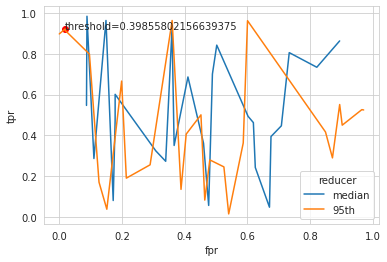

In [ ]:
plot = sns.lineplot(data=df, x='fpr', y='tpr', hue='reducer')
plt.scatter(x=df.fpr[index_optThr], y=df.tpr[index_optThr], color='r')
plt.gca().text(df.fpr[index_optThr], df.tpr[index_optThr], 'threshold='+str(df.threshold[index_optThr]))